# Function interpolation - simulation study 

This notebook runs a simple simulation study comparing the performance of multidimensional interpolation methods.

Ultimately, the goal is to implement interpolation methods in *respy*, an open-source Python package for the estimation of dynamic discrete-choice models.

# Motivation




...

# Theoretical Framework

...

# Simulation study

## Import necessary packages:

In [1]:
%load_ext autoreload
%matplotlib inline

import os
import pickle
import sys

root = os.path.dirname(os.path.abspath(sys.argv[0]))
sys.path.insert(0, root)

import matplotlib.pyplot as plt
import numpy as np
from time import time

from src.functions_to_approximate import borehole_numba as borehole
from src.functions_to_approximate import zhou_vectorize as zhou
from src.auxiliary import get_grid
from src.auxiliary import get_interpolation_points
from src.auxiliary import rmse as root_mean_squared_error
from src.parameters import study_params
from src.parameters import interp_params

## Benchmark: Smolyak interpolation

### Set parameters

In [3]:
study_params["controls"] = {
    "load data": False,
    "method": "smolyak",
    "grid size": "medium",
    "variables": [2, 3, 4, 5, 6, 7, 8],
    "function to approximate": zhou,
    "number of points for accuracy check": 1000,
    "seed for accuracy check": 123,
}


### Execute interpolation

In [4]:
# load parameters
method = study_params["controls"]["method"]
func = study_params["controls"]["function to approximate"]
grid_size = study_params["controls"]["grid size"]
iterations = study_params[method]["iterations"]
interpolator = study_params[method]["interpolator"]
n_interpolation_points = study_params["controls"][
    "number of points for accuracy check"
]
accuracy_check_seed = study_params["controls"]["seed for accuracy check"]

# initiate dict to store results
results = {}
results[method] = {"rmse": {}, "runtime": {}, "gridpoints": {}}

for n_vars in study_params["controls"]["variables"]:

    # generate grid
    n_gridpoints = study_params["grid"]["zhou"]["n_gridpoints"][grid_size]
    grid_min = study_params["grid"]["zhou"]["lower bounds"][:n_vars]
    grid_max = study_params["grid"]["zhou"]["upper bounds"][:n_vars]
    dims_state_grid = np.array(object=[n_gridpoints] * n_vars, dtype=int,)
    n_states = dims_state_grid.prod()
    grid = get_grid(dims_state_grid, grid_min, grid_max)
    index = np.array(object=range(n_states))

    # get interpolation points
    interpolation_points = get_interpolation_points(
        n_interpolation_points, grid, accuracy_check_seed,
    )

    # get results on interpolation points
    results_calc = func(interpolation_points)

    # initiate objects to store results
    rmse_tmp = []
    runtime_tmp = []
    n_gridpoints_effective_tmp = []

    # iterate over settings
    for iteration in range(iterations):
        print(f"dimension: {n_vars}; iteration: {iteration + 1}")

        # adjust interpolation parameters
        if study_params["controls"]["method"] == "linear":
            interp_params["linear"]["interpolation_points"] = study_params[
                "linear"
            ]["interpolation_points"][iteration]
        elif study_params["controls"]["method"] == "spline":
            interp_params["spline"]["interpolation_points"] = study_params[
                "spline"
            ]["interpolation_points"][iteration]
        elif study_params["controls"]["method"] == "smolyak":
            interp_params["smolyak"]["mu"] = study_params["smolyak"]["mu"][
                iteration
            ]

        # interpolate and capture computation time
        start = time()
        results_interp, n_gridpoints_effective = interpolator(
            interpolation_points, grid, func, interp_params
        )
        stop = time()

        # assess interpolation accuracy
        rmse_iter = root_mean_squared_error(results_interp, results_calc)

        # print and store results
        print("root mean squared error: " + method + f" {rmse_iter}")
        print("computation time: " + method + " {}".format(stop - start))
        print(f"gridpoints: {n_gridpoints_effective}")

        rmse_tmp.append(rmse_iter)
        runtime_tmp.append(stop - start)
        n_gridpoints_effective_tmp.append(n_gridpoints_effective)

    results[method]["rmse"][n_vars] = np.array(object=rmse_tmp)
    results[method]["runtime"][n_vars] = np.array(object=runtime_tmp)
    results[method]["gridpoints"][n_vars] = np.array(
        object=n_gridpoints_effective_tmp
    )

dimension: 2; iteration: 1
root mean squared error: smolyak 1.6858871505140047
computation time: smolyak 0.055295467376708984
gridpoints: 5
dimension: 2; iteration: 2
root mean squared error: smolyak 1.7200906422390565
computation time: smolyak 0.001268148422241211
gridpoints: 13
dimension: 2; iteration: 3
root mean squared error: smolyak 1.4315442351674423
computation time: smolyak 0.0
gridpoints: 29
dimension: 3; iteration: 1
root mean squared error: smolyak 3.0111593104486882
computation time: smolyak 0.0
gridpoints: 7
dimension: 3; iteration: 2
root mean squared error: smolyak 3.0227576449922062
computation time: smolyak 0.0
gridpoints: 25
dimension: 3; iteration: 3
root mean squared error: smolyak 2.8342841761913924
computation time: smolyak 0.0
gridpoints: 69
dimension: 4; iteration: 1
root mean squared error: smolyak 5.043718100694837
computation time: smolyak 0.0
gridpoints: 9
dimension: 4; iteration: 2
root mean squared error: smolyak 5.027349945921068
computation time: smolya

In [5]:
print(results["smolyak"]["rmse"])
print(results["smolyak"]["runtime"])

{2: array([1.68588715, 1.72009064, 1.43154424]), 3: array([3.01115931, 3.02275764, 2.83428418]), 4: array([5.0437181 , 5.02734995, 4.94750246]), 5: array([7.85613468, 7.82034818, 7.75187682]), 6: array([2.90502455, 2.71388041, 3.66639509]), 7: array([5.82099   , 5.70215227, 6.29999523]), 8: array([6.70698305, 6.59885164, 7.11568736])}
{2: array([0.05529547, 0.00126815, 0.        ]), 3: array([0., 0., 0.]), 4: array([0., 0., 0.]), 5: array([0.        , 0.01562119, 0.        ]), 6: array([0.00196981, 0.00422668, 0.01695395]), 7: array([0.00099707, 0.00398803, 0.03889537]), 8: array([0.02393436, 0.01096988, 0.07948279])}


# Plot results

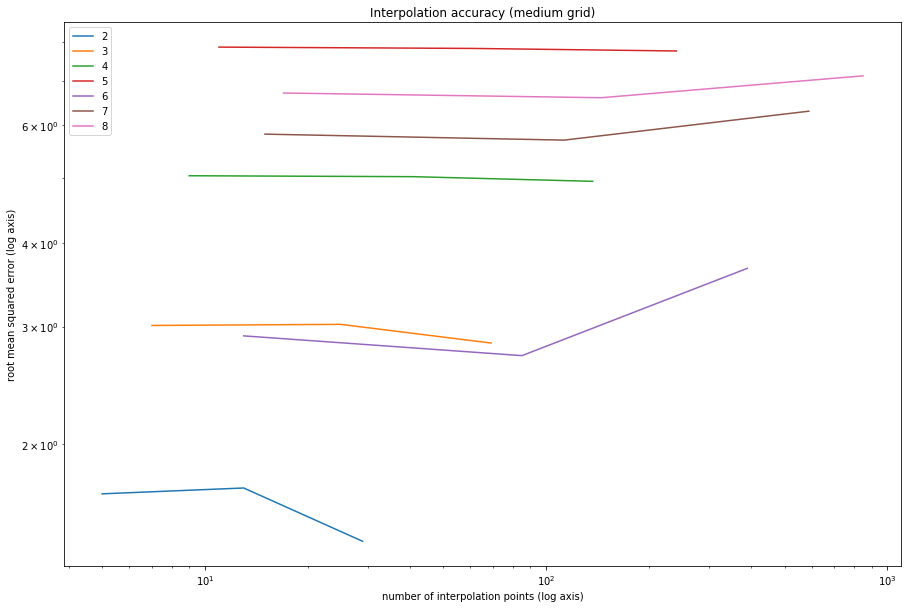

In [6]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 10]

plot_legend = []
plot_x = []
plot_y = []
for n_vars in study_params["controls"]["variables"]:
    plot_legend.append(n_vars)
    plot_x.append(results[method]["gridpoints"][n_vars])
    plot_y.append(results[method]["rmse"][n_vars])

for idx in range(len(study_params["controls"]["variables"])):
    plt.plot(plot_x[idx], plot_y[idx])

plt.xscale("log")
plt.yscale("log")
plt.xlabel("number of interpolation points (log axis)")
plt.ylabel("root mean squared error (log axis)")
plt.legend(plot_legend)
plt.title("Interpolation accuracy (" + grid_size + " grid)")
plt.show()

# References

...